In [1]:
import numpy as np
import tensorflow as tf
# Display
import cv2, os, glob, random, tqdm
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras import backend as K

from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from utils import lr_schedule
from models import resnext

In [3]:
ramdom_seed = 5198
tf.random.set_seed(ramdom_seed)
np.random.seed(ramdom_seed)
random.seed(ramdom_seed)
os.environ['PYTHONHASHSEED'] = str(ramdom_seed)

In [6]:
tf.__version__
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17462899301816805768,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1843478790054111530
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 48242412749
 locality {
   bus_id: 2
   numa_node: 1
   links {
   }
 }
 incarnation: 12036510121034581687
 physical_device_desc: "device: 0, name: Quadro RTX 8000, pci bus id: 0000:da:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14058260804998075776
 physical_device_desc: "device: XLA_GPU device"]

In [7]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
# Invalid device or cannot modify virtual devices once initialized.
    pass

In [8]:
def load_data(path):
    folder_list = sorted(glob.glob(path + '/*'))

    all_data = []
    all_label = []
    lab = 0.
    for class_path in tqdm.tqdm(folder_list):  
        data_list = glob.glob(class_path + '/*.jpg')
        for tmp in data_list: 
            img = cv2.imread(tmp)
            img = cv2.resize(img, (256,256))
            all_data.append(img)
            all_label.append(lab)
        lab += 1.
    all_data = np.array(all_data)
    all_label = np.array(all_label)
    return all_data, all_label

In [9]:
# Training parameters
batch_size = 32
epochs = 50
data_augmentation = False
num_classes = 2
subtract_pixel_mean = True  # Subtracting pixel mean improves accuracy
base_model = 'resnet20'
# Choose what attention_module to use: cbam_block / se_block / None
attention_module = 'cbam_block'
model_type = base_model if attention_module==None else base_model+'_'+attention_module

## Load data

In [10]:
v1_data_path = '/sgcwhb/3rd_Molar_toCanal/3rd_Moral_Data/latest_data/Unlabeled_Cropped_Data/PNG/'
v3_data_path = '/sgcwhb/3rd_Molar_toCanal/3rd_Moral_Data/latest_data/New_V3_Unlabeled_Data/PNG/'
v2_data_path = '/sgcwhb/3rd_Molar_toCanal/3rd_Moral_Data/latest_data/New_V2_Unlabeled_Data/PNG/'

v1, v1_lab = load_data(v1_data_path)
v2, v2_lab = load_data(v2_data_path)
v3, v3_lab = load_data(v3_data_path)

100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


In [11]:
count = np.zeros((4))
for i in v1_lab:
    for x in range(4):
        if i == x:
            count[x] += 1

# X_train = np.concatenate((np.tile(v1[:int(count[0])], (8,1,1,1)),v1[int(count[0]):]))
# Y_train = np.concatenate((np.tile(np.zeros((int(count[0]))),(8)), np.ones(int(np.sum(count[1:])))))

X1_train = v1
Y1_train = np.concatenate((np.zeros((int(count[0]))), np.ones(int(np.sum(count[1:])))))

count3 = np.zeros((4))
for i in v3_lab:
    for x in range(4):
        if i == x:
            count3[x] += 1

X3_train = v3
Y3_train = np.concatenate((np.zeros((int(count3[0]))), np.ones(int(np.sum(count3[1:])))))

count2 = np.zeros((4))
for i in v2_lab:
    for x in range(4):
        if i == x:
            count2[x] += 1

X2_train = v2
Y2_train = np.concatenate((np.zeros((int(count2[0]))), np.ones(int(np.sum(count2[1:])))))

In [12]:
x_train=np.concatenate((X1_train,X3_train,X2_train),axis=0)
y_train=np.concatenate((Y1_train,Y3_train,Y2_train),axis=0)

In [13]:
print(x_train.shape,"||", y_train.shape) 

(823, 256, 256, 3) || (823,)


In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15, random_state=42, stratify=y_train)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [15]:
print("TRAIN shape:", x_train.shape)
print("Validation shape:", x_val.shape)
print("TEST shape:", x_test.shape)

TRAIN shape: (559, 256, 256, 3)
Validation shape: (140, 256, 256, 3)
TEST shape: (124, 256, 256, 3)


In [16]:
print(len(np.where(y_train==0)[0]),"||",len(np.where(y_train==1)[0]))
print(len(np.where(y_val==0)[0]),"||",len(np.where(y_val==1)[0]))
print(len(np.where(y_test==0)[0]),"||",len(np.where(y_test==1)[0]))

90 || 469
23 || 117
20 || 104


In [17]:
def imresize_(np_tensor, size):
    img_all = []
    for img in np_tensor:
        img_all.append(cv2.resize(img, (size, size)))
    return np.array(img_all)

In [18]:
x_train = imresize_(x_train,224) /255.
x_val = imresize_(x_val,224) /255.
x_test = imresize_(x_test,224) /255.

In [19]:
# if subtract_pixel_mean:
#     x_train_mean = np.mean(x_train, axis=0)
#     x_train -= x_train_mean
#     x_val -= x_train_mean
#     x_test -= x_train_mean

In [20]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'val samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)


x_train shape: (559, 224, 224, 3)
559 train samples
140 val samples
124 test samples
y_train shape: (559,)


In [21]:
# Input image dimensions.
input_shape = x_train.shape[1:]

In [22]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val= keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

--------
## 2.model

In [23]:
# depth = 11 # For ResNet, specify the depth (e.g. ResNet50: depth=50)
base_model = resnext.ResNextImageNet(include_top=False,input_shape=input_shape, weights="imagenet", attention_module=attention_module)

In [24]:
def build_model():
    
    c = base_model.output

    c = keras.layers.GlobalAveragePooling2D()(c)
    c = keras.layers.Dense(256, activation='relu', name='dense_1', kernel_regularizer=tf.keras.regularizers.l1(0.0001))(c)
    c = keras.layers.Dropout(0.3)(c)
    c = keras.layers.Dense(64, activation='relu', name='dense_2', kernel_regularizer=tf.keras.regularizers.l1(0.0001))(c)
    c = keras.layers.Dropout(0.3)(c)
    outputs = keras.layers.Dense( 2 , activation = 'softmax', name='prediction')(c)

    model = Model(inputs=base_model.input, outputs=outputs)
    
    return model

In [25]:
model=build_model()

In [26]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(0.005),
              metrics=['accuracy'])

In [27]:
print(model_type)

resnet20_cbam_block


In [113]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1098 (Conv2D)            (None, 112, 112, 64) 9408        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_106 (BatchN (None, 112, 112, 64) 256         conv2d_1098[0][0]                
__________________________________________________________________________________________________
leaky_re_lu_98 (LeakyReLU)      (None, 112, 112, 64) 0           batch_normalization_106[0][0]    
____________________________________________________________________________________________

In [28]:
model_list = []
for i in model.layers:
    model_list.append(i.name)

freeze_block = "leaky_re_lu_47"
freeze_block_idx = model_list.index(freeze_block)
for i in model.layers[:freeze_block_idx]:
    i.trainable = False

In [61]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_549 (Conv2D)             (None, 112, 112, 64) 9408        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 112, 112, 64) 256         conv2d_549[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_49 (LeakyReLU)      (None, 112, 112, 64) 0           batch_normalization_53[0][0]     
____________________________________________________________________________________________

In [29]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models','01')
model_name = '%s_model-{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [30]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath, save_weights_only=True)
csv_logger = CSVLogger(os.path.join(save_dir, r'log.csv'), append=True)
lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, csv_logger, lr_scheduler, lr_reducer]
callbacks = [checkpoint, csv_logger]

# TRAIN

### if not data_augmentation:

In [31]:
x_train.shape

(559, 224, 224, 3)

In [32]:
print('Not using data augmentation.')
model_hist=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val),
          shuffle=True,
          callbacks=callbacks)

Not using data augmentation.
Train on 559 samples, validate on 140 samples
Epoch 1/50
559/559 [==============================] - 51s 91ms/sample - loss: 36.1506 - accuracy: 0.8032 - val_loss: 36.3249 - val_accuracy: 0.8143
Epoch 2/50
559/559 [==============================] - 8s 14ms/sample - loss: 36.0575 - accuracy: 0.8354 - val_loss: 36.0386 - val_accuracy: 0.8357
Epoch 3/50
559/559 [==============================] - 8s 14ms/sample - loss: 36.0106 - accuracy: 0.8301 - val_loss: 36.0138 - val_accuracy: 0.8357
Epoch 4/50
559/559 [==============================] - 8s 14ms/sample - loss: 36.0242 - accuracy: 0.8390 - val_loss: 36.0877 - val_accuracy: 0.8357
Epoch 5/50
559/559 [==============================] - 8s 14ms/sample - loss: 36.0007 - accuracy: 0.8354 - val_loss: 36.0244 - val_accuracy: 0.8357
Epoch 6/50
559/559 [==============================] - 8s 14ms/sample - loss: 35.9710 - accuracy: 0.8390 - val_loss: 36.0471 - val_accuracy: 0.8357
Epoch 7/50
559/559 [======================

KeyError: 'val_accuracy'

In [119]:
model.load_weights('saved_models/test.h5')

### else:

In [ ]:
def image_aug_batch(img):
    # images = h w c
    # label bbox = (left, top, right, bottom)
    seq = iaa.Sequential([
    iaa.Multiply((0.9, 1.1)),
    iaa.Add((-10,10)),
    iaa.Affine(
        translate_px={"x": 30, "y": 30},
        scale=(0.90, 1.1),
        rotate=(-10, 10),
        mode="edge")])
    images_aug = seq(images = img.astype(np.float32)/255.)
    return images_aug

In [ ]:
def data_generator(train_imgs, train_labels, batch_size, aug = True):
    idx = 0
    while 1:
        idx_list = list(range(0,len(train_imgs)))
        random.shuffle(idx_list)
        if idx > len(idx_list) - batch_size:
            tmp_list = idx_list[idx:]
            idx = 0
        else:
            tmp_list = idx_list[idx:idx + batch_size]
            idx = idx + batch_size
        batch_images = train_imgs[tmp_list]
        batch_labels = train_labels[tmp_list]
        
        if aug == True:
            batch_images = image_aug_batch(batch_images)
            batch_images = (batch_images * 255).astype(np.uint8)
            batch_images = np.clip(batch_images, 0, 255)
            
        yield preprocess_input(batch_images), to_categorical(batch_labels)

In [ ]:
train_gen = data_generator(x_train, y_train, batch_size, aug = True)
val_gen = data_generator(x_val, y_val, batch_size, aug = False)

In [25]:
print('Using real-time data augmentation.')

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(train_gen, 
                    steps_per_epoch =3,
                    validation_data=val_gen,
                    validation_steps = 1,
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=callbacks)

Not using data augmentation.
Train on 749 samples, validate on 74 samples
Epoch 1/200
Learning rate:  0.001
749/749 [==============================] - 33s 44ms/step - loss: 0.8073 - accuracy: 0.7837 - val_loss: 0.7509 - val_accuracy: 0.7162
Epoch 2/200
Learning rate:  0.001


C:\Users\bomsi\anaconda3\envs\python3.7\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


749/749 [==============================] - 26s 34ms/step - loss: 0.5391 - accuracy: 0.8531 - val_loss: 0.7463 - val_accuracy: 0.7162
Epoch 3/200
Learning rate:  0.001
749/749 [==============================] - 26s 34ms/step - loss: 0.4902 - accuracy: 0.8665 - val_loss: 0.7545 - val_accuracy: 0.7162
Epoch 4/200
Learning rate:  0.001
749/749 [==============================] - 26s 34ms/step - loss: 0.4308 - accuracy: 0.8838 - val_loss: 0.7383 - val_accuracy: 0.7162
Epoch 5/200
Learning rate:  0.001
749/749 [==============================] - 26s 34ms/step - loss: 0.3705 - accuracy: 0.9132 - val_loss: 0.7725 - val_accuracy: 0.7297
Epoch 6/200
Learning rate:  0.001
749/749 [==============================] - 26s 34ms/step - loss: 0.2991 - accuracy: 0.9413 - val_loss: 1.2362 - val_accuracy: 0.3649
Epoch 7/200
Learning rate:  0.001
749/749 [==============================] - 26s 34ms/step - loss: 0.2740 - accuracy: 0.9573 - val_loss: 0.6714 - val_accuracy: 0.7838
Epoch 8/200
Learning rate:  0.00

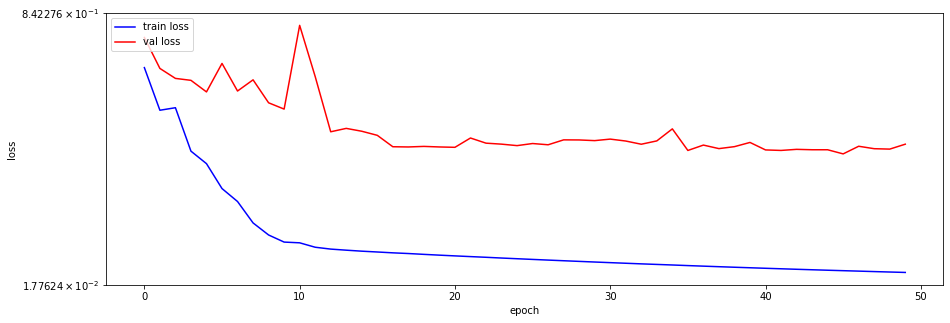

In [32]:
fig, loss_ax = plt.subplots(figsize =(15,5))

loss_ax.plot(model_hist.history['loss'], 'b', label='train loss')
loss_ax.plot(model_hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')
loss_ax.set_yscale('symlog')

plt.show()

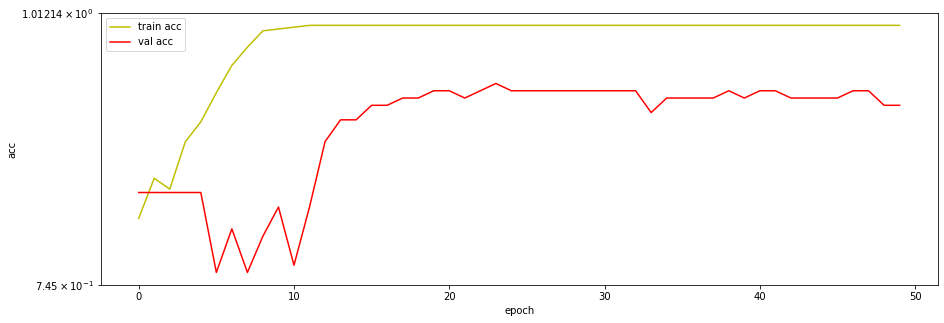

In [33]:
fig, loss_ax = plt.subplots(figsize =(15,5))

loss_ax.plot(model_hist.history['accuracy'], 'y', label='train acc')
loss_ax.plot(model_hist.history['val_accuracy'], 'r', label='val acc')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('acc')
loss_ax.legend(loc='upper left')
loss_ax.set_yscale('symlog')

plt.show()

# evaluate

In [120]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

124/124 [==============================] - 2s 20ms/sample - loss: 0.4341 - accuracy: 0.9677
Test loss: 0.4340804132723039
Test accuracy: 0.9677419


In [128]:
lab= y_test
predict=model.predict(x_test)

In [31]:
np.round(predict,2)

array([[0.  , 1.  ],
       [0.  , 1.  ],
       [0.97, 0.03],
       [0.88, 0.12],
       [0.17, 0.83],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.88, 0.12],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.91, 0.09],
       [0.08, 0.92],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.04, 0.96],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.04, 0.96],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.03, 0.97],
       [0.99, 0.01],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.68, 0.32],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.99,

In [30]:
lab

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [131]:
predict[predict> 0.5] = 1
predict[predict< 0.5] = 0

In [132]:
from sklearn.metrics import classification_report

y_train = np.argmax(lab, axis=1) # Convert one-hot to index
y_pred = np.argmax(predict, axis=1) # Convert` one-hot to index
print(classification_report(y_train, y_pred, target_names = ['0','1']))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89        20
           1       0.97      0.99      0.98       104

    accuracy                           0.97       124
   macro avg       0.96      0.92      0.94       124
weighted avg       0.97      0.97      0.97       124



In [133]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_train, y_pred)
confusion_mat

array([[ 17,   3],
       [  1, 103]], dtype=int64)

# Grad_cam

In [121]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [156]:
model_list = []
for i in model.layers:
    model_list.append(i.name)
    
last_conv_layer_name = "average_pooling2d"
last_c_idx = model_list.index(last_conv_layer_name)
classifier_layer_names = model_list[last_c_idx+1:]

In [157]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.outputs]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = int(np.array(tf.argmax(preds[0][0])))
        class_channel = preds[0][:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return preds, heatmap.numpy()

label =  [0. 1.]    predict =  [[[0. 1.]]]


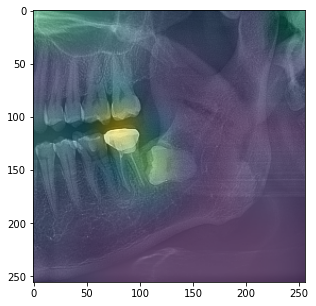

In [219]:
idx = 10
preds, heatmap = make_gradcam_heatmap(x_test[idx:idx+1], model, last_conv_layer_name)


img = np.array(keras.preprocessing.image.array_to_img(x_test[idx]))

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("viridis")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.6 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
plt.figure(figsize=(5,5))
plt.imshow(superimposed_img)
print('label = ', y_test[idx], '   predict = ', np.round(np.array(preds),2))
plt.show()

label =  [0. 1.]    predict =  [[[0. 1.]]]


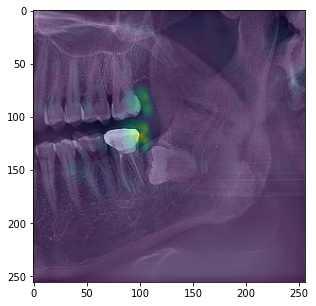

In [220]:
att_model = tf.keras.models.Model([model.inputs], [model.get_layer('lambda_15').output])
tmp_test = att_model(x_test[idx:idx+1])
tmp_test = np.array(tmp_test)
tmp_test = tmp_test / tmp_test.max()
img = np.array(keras.preprocessing.image.array_to_img(x_test[idx]))

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * tmp_test[0,...,0])

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("viridis")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.6 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
plt.figure(figsize=(5,5))
plt.imshow(superimposed_img)
print('label = ', y_test[idx], '   predict = ', np.round(np.array(preds),2))
plt.show()

In [216]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

idx = widgets.IntSlider(min=0, max=len(x_test), step=1)

preds = model.predict(x_test)

def printer(idx):
    test_i = idx

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(
        x_test[idx:idx+1], model, last_conv_layer_name)


    img = np.array(keras.preprocessing.image.array_to_img(x_test[idx]))

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("viridis")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((x_test.shape[1], x_test.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.9 + x_test
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    plt.figure(figsize=(5,5))
    plt.imshow(superimposed_img)
    print('label = ', y_test[test_i], '   predict = ', preds[test_i])
    plt.show()
    
interact(printer, idx = idx, img = x_test)

ValueError: setting an array element with a sequence.

<function __main__.printer(idx)>